# Intro Task, Object Localization 

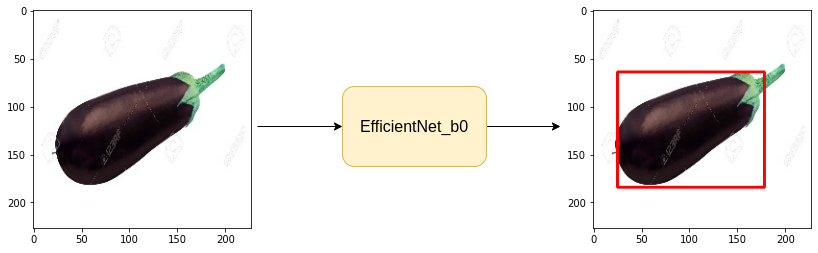

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1ucnip2b
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1ucnip2b
     |████████████████████████████████| 47.8 MB 70 kB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=9dcb4ce08faf8e96d15d23784d499cacc61a43dc81a2efffe09d02cea4bd94c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-pm26qzb4/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 29.79 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"

DEVICE = "cuda"

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = "efficientnet_b0"

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

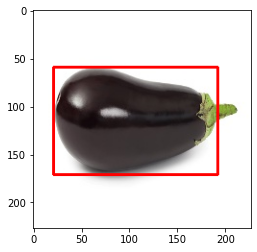

In [7]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [8]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42) 

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields = ["class_labels"]))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params=A.BboxParams(format="pascal_voc", label_fields = ["class_labels"]))

# Create Custom Dataset

In [11]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels= [None])
      img = data["image"]
      bbox = data["bboxes"][0]

    img =torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c) -> (c,h,w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [12]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)   

In [13]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


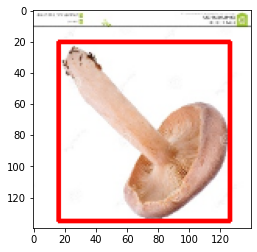

In [14]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
    break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn 
import timm

In [19]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()

        self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

    def forward(self, images, gt_bboxes = None):

        bboxes = self.backbone(images)

        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss

        return bboxes

In [21]:
model = ObjLocModel()
model.to(DEVICE);

In [22]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [23]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()

    for data in tqdm(dataloader):

        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/ len(dataloader)

In [24]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataloader)

#Training Loop

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [26]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} train loss: {train_loss} valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 1 train loss: 5454.9432373046875 valid_loss : 8810.85498046875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 2 train loss: 2041.5269775390625 valid_loss : 3413.0812174479165


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 3 train loss: 1159.4056518554687 valid_loss : 474.8441467285156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 4 train loss: 777.3231811523438 valid_loss : 178.90036010742188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 train loss: 550.4186248779297 valid_loss : 182.42738342285156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss: 411.8226119995117 valid_loss : 188.8813273111979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 7 train loss: 342.6180847167969 valid_loss : 168.77232869466147


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 8 train loss: 196.76241760253907 valid_loss : 149.34859212239584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 9 train loss: 173.54416732788087 valid_loss : 136.9935506184896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss: 155.5880920410156 valid_loss : 156.439328511556


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 11 train loss: 133.21459579467773 valid_loss : 102.69050598144531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss: 107.82745208740235 valid_loss : 136.49920145670572


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss: 94.97432441711426 valid_loss : 135.59242248535156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss: 85.43054161071777 valid_loss : 113.6881841023763


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 15 train loss: 96.54308013916015 valid_loss : 100.86094665527344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 16 train loss: 99.37223072052002 valid_loss : 98.11006418863933


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss: 67.35642013549804 valid_loss : 140.86566162109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 18 train loss: 68.61623306274414 valid_loss : 92.00759379069011


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 19 train loss: 75.72011032104493 valid_loss : 77.35716756184895


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 20 train loss: 55.85875053405762 valid_loss : 60.725390116373696


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 21 train loss: 53.74674644470215 valid_loss : 52.829568227132164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss: 45.240971374511716 valid_loss : 73.5590591430664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss: 50.977348709106444 valid_loss : 78.43221028645833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss: 45.53115997314453 valid_loss : 104.77378336588542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss: 49.0957691192627 valid_loss : 73.1510403951009


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss: 47.17135639190674 valid_loss : 82.30431747436523


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss: 49.768357849121095 valid_loss : 64.88966369628906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss: 48.61790885925293 valid_loss : 74.0714734395345


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss: 47.36921157836914 valid_loss : 117.9070816040039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss: 38.51417198181152 valid_loss : 76.863218943278


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss: 52.11131591796875 valid_loss : 87.97306315104167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss: 52.818697929382324 valid_loss : 110.70706176757812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss: 53.00487651824951 valid_loss : 102.06424204508464


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss: 49.31675796508789 valid_loss : 69.31144332885742


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 35 train loss: 47.4171703338623 valid_loss : 49.828267415364586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss: 42.27868785858154 valid_loss : 67.02103424072266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss: 47.382744026184085 valid_loss : 60.69073486328125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss: 38.18419075012207 valid_loss : 67.71797943115234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss: 28.40343360900879 valid_loss : 60.48067982991537


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss: 44.862242698669434 valid_loss : 61.86994425455729


#Inference

In [27]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


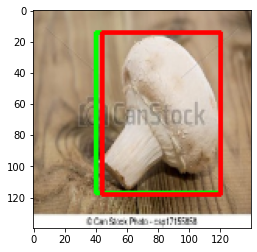

In [29]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():

    image, gt_bbox = validset[23] #(c,h,w)
    image = image.unsqueeze(0).to(DEVICE) #(bs, c,h,w)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya